In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, PillowWriter
import random
import skops.io as sio
import itertools as it
from sklearn.model_selection import KFold
from sklearn.metrics import top_k_accuracy_score, average_precision_score, log_loss, accuracy_score
from IPython.display import display, clear_output, HTML
import gc

## Classificação de imagens reais e falsas

### Dataset 
O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB

In [4]:
def load(arr, path):
    for filename in os.listdir(path):
        arr.append(np.reshape(cv2.imread(os.path.join(path, filename)), (3072,)))

In [5]:
if not os.path.exists("test.txt"):
    test_x = []
    load(test_x, "test/FAKE/")
    load(test_x, "test/REAL/")
    train_x = []
    load(train_x, "train/FAKE/")
    load(train_x, "train/REAL/")
    # Os dados são salvos como arquivo binário para acelerar a leitura dos dados
    # na próxima leitura
    np.array(test_x, dtype=np.uint8).tofile("test.txt")
    np.array(train_x, dtype=np.uint8).tofile("train.txt")

Os dados são números inteiros de 0 a 255 representando o valor de cada pixel, para normalizar os dados precisamos apenas dividir todos os valores por 255

In [6]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3)) / 255
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3)) / 255
print(test_x.shape, train_x.shape)

(20000, 32, 32, 3) (100000, 32, 32, 3)


Os dados estão distribuídos de forma que a primeira metade dos dados faz parte da classe falsa e a segunda metade da classe real. Os vetores y são preenchidos com 0s e 1s de acordo com as classes

In [7]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


### Imagens do dataset
As imagens que compõem o dataset são imagens de aviões, automóveis, pássaros, cervos, gatos, cachorros, sapos, cavalos, navios e caminhões. Todas as imagens tem características diferentes não seguindo padrões aparentes

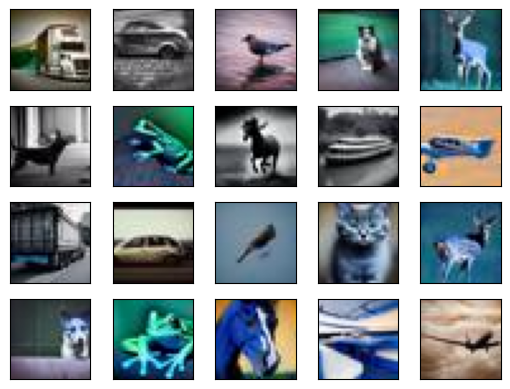

In [8]:
for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x[i-1])


In [9]:
def auxiliar_indexes(data_size, aux_data_size):
    aux_data_size = int(aux_data_size/2)
    half = int(data_size / 2)
    indexes = list(range(half-aux_data_size, half+aux_data_size))
    random.shuffle(indexes)
    return indexes


In [10]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

In [11]:
aux_test_i = auxiliar_indexes(len(flat_test_x), 400)
aux_train_i = auxiliar_indexes(len(flat_train_x), 2000)


### K-vizinhos mais próximos (Knn)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

A primeira solução para resolver o problema vai ser o modelo de K-vizinhos mais próximos. O primeiro passo é decidir os hiper parâmetros do modelo, para isso vamos testar os valores do parâmetro k de 1 a 20 e comparar os resultados obtidos com cada valor de k

In [13]:
def to_sparse(value):
    res = np.zeros((2,))
    res[int(value)] = 1
    return res

In [14]:
knn_scores = []

if os.path.exists("knn_scores3.npy"):
    with open('knn_scores3.npy', 'rb') as f:
        knn_scores = np.load(f, allow_pickle=True)
else:
    iterations = 10
    a = [auxiliar_indexes(len(flat_test_x), 1200) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 4800) for _ in range(iterations)]
    for i in range(1, 21):
        mean = []
        for k in range(iterations):
            knn_model = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
            knn_model.fit(flat_train_x[b[k]], train_y[b[k]])
            y_true = [to_sparse(x) for x in test_y[a[k]]]
            proba = knn_model.predict_proba(flat_test_x[a[k]])
            pred = [np.argmax(x) for x in proba]
            mean.append([accuracy_score(test_y[a[k]],pred), 
                         log_loss(test_y[a[k]], proba), 
                         average_precision_score(y_true, proba),])
            gc.collect()
        knn_scores.append(mean)

In [15]:
values = np.transpose(knn_scores, (0,2,1))

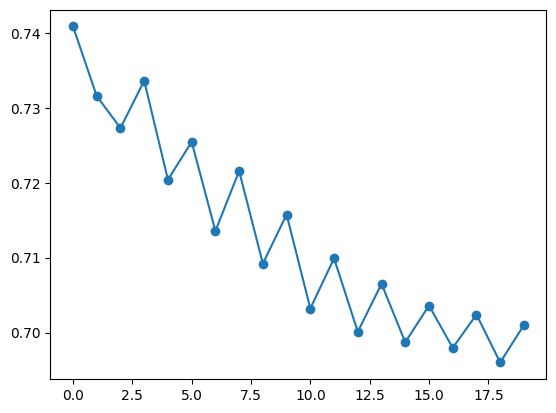

In [16]:
plt.close()
plt.plot(np.mean(values[:, 0, :], axis=1), '-o')
plt.show()
# plt.plot(np.mean(values[:,2,:], axis=1))
# plt.show()
# plt.plot(values[:, 1, 0]/(np.max(values[:, 1, 0])))

Para cada valor de k testamos a precisão do modelo 30 vezes randomizando os dados, após obtermos os resultados podemos plotar um gráfica para mostrar a relação dos valores

Apesar dos resultados variarem bastante ao plotarmos a media e a mediana das 30 iterações o gráfico forma algo parecido com uma curva crescente achatada e é o bastante para determinar o valor de k com o melhor resultado

In [17]:
if not os.path.exists('knn_scores3.npy'):
    with open('knn_scores3.npy', 'wb') as f:
        np.save(f, np.array(knn_scores,dtype=object), allow_pickle=True)

In [18]:
n = range(1, 20)[np.argmax([np.mean(x) for x in knn_scores])]
print(f'Best k value: {n}')

Best k value: 1


com o valor de k que obteve o melhor resultado vamos treinar o modelo com o resto dos dados

In [19]:
with open('final_knn_score.npy', 'rb') as f:
    final_knn_score = np.load(f, allow_pickle=True).flatten()[0]

In [20]:
if not os.path.exists("final_knn_score.npy"):
    knn_model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    knn_model.fit(flat_train_x, train_y)
    knn_proba = knn_model.predict_proba(flat_test_x)
    final_knn_score = knn_model.score(flat_test_x, test_y)
    sio.dump(sio.dumps(knn_proba), 'knn_proba')
print("Accuracy: ", final_knn_score)


Accuracy:  0.74085


O modelo knn funciona de forma simples, ele agrupa os valores de acordo com as suas proximidade e faz predições calculando a proximidade do valor de entrada com os grupos, assim o sucesso do modelo depende da previsibilidade dos dados já que valores afastados dos grupos com suas classes correspondentes não teriam o resultado correto

Como falado anteriormente as imagens do dataset não seguem padrão específico e portando os valores dos pixels nas imagens não são próximos uns dos outros o bastante para obtermos a melhor precisão, no entanto ainda conseguimos chegar em um score perto de 75%

#### Por que esse valor?

In [21]:
def plot_knn_vis(n):
    int_train = np.fromfile("train.txt", dtype=np.uint8).reshape(100000, 3072)
    int_test = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 3072))
    xx_i = auxiliar_indexes(len(train_y), 100000)
    xx = int_train[xx_i][:, :2]
    yy = train_y[xx_i]
    knn_model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    knn_model.fit(xx, yy)

    xx_train_ax = np.array(list(it.product(range(0, 256, 5), repeat=2)))
    xx_ax = xx_train_ax.transpose()[0]
    xx_ay = xx_train_ax.transpose()[1]

    c_map1 = ['#eba8f0', '#a8b4f0']
    c_map2 = ['#d751e1', '#5169e1']
    c_map3 = ['r', 'b']
    proba = knn_model.predict_proba(xx_train_ax)
    nm = int(np.sqrt(xx_train_ax.shape[0]))
    z = np.transpose([[proba[i*nm+j].argmax() for j in range(nm)] for i in range(nm)])
    sizes = np.max(proba, axis=1)**3 * 30
    colors = [c_map1[int(x)] for x in knn_model.predict(xx_train_ax)]
    plt.scatter(xx_ax, xx_ay,s=sizes, c=colors, linewidths=0, alpha=0.5)
    plt.contour(range(0,256,5), range(0,256,5), z, linewidths=1, levels=1, colors=c_map2)

    count = 100
    xx_i = auxiliar_indexes(len(test_y), count)
    xx = int_test[xx_i][:, :2]
    yy = test_y[xx_i]
    colors = [c_map3[int(x)] for x in yy]
    plt.scatter(xx[:,0], xx[:,1],c=colors, s=20, alpha=1)
    plt.legend([plt.Line2D([0], [0], linestyle='', marker='o', color='r'),
            plt.Line2D([0], [0], linestyle='', marker='o', color='b')], ['Fake', 'Real'], loc='lower right')

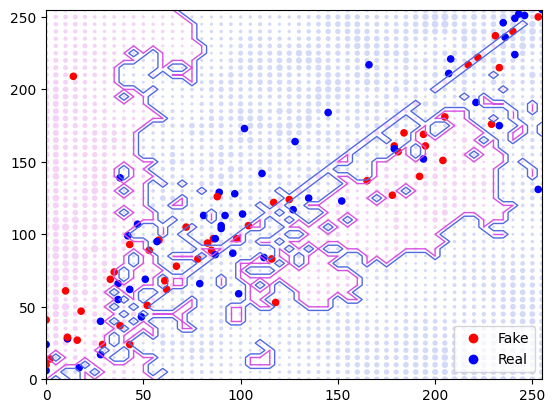

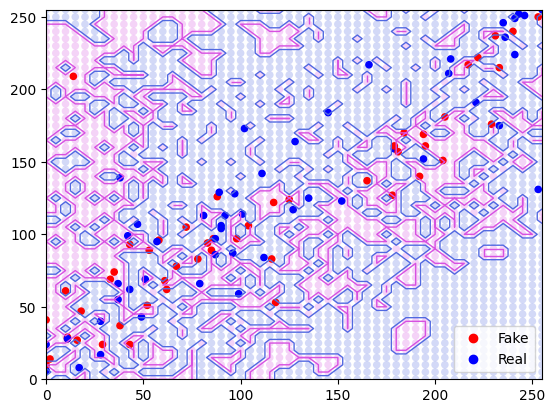

In [22]:
plt.close()
plot_knn_vis(29)
plt.show()
plot_knn_vis(1)
plt.show()

In [23]:
knn_proba = sio.loads(sio.load('knn_proba'))

In [24]:
if not os.path.exists('final_knn_score.npy'):
    with open('final_knn_score.npy', 'wb') as f:
        np.save(f, np.array(final_knn_score,dtype=object), allow_pickle=True)

### Árvore de decisão

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Para a definição dos parâmetros do modelo de árvore usaremos a mesma estratégia usada no modelo knn

In [26]:
tree_scores = []
criterions = ["gini", "entropy", "log_loss"]
max_depths = range(5, 14, 2)

if not os.path.exists("tree_scores5.npy"):
    iterations = 1
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 5000) for _ in range(iterations)]
    for comb in it.product(criterions, max_depths):
        mean = []
        for k in range(iterations):
            tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
            tree_model.fit(flat_train_x[b[k]], train_y[b[k]])
            proba = tree_model.predict_proba(flat_test_x[a[k]])
            pred = [np.argmax(x) for x in proba]
            mean.append([accuracy_score(test_y[a[k]], pred),])
        tree_scores.append(mean)

In [27]:
if not os.path.exists('tree_scores5.npy'):
    with open('tree_scores5.npy', 'wb') as f:
        np.save(f, np.array(tree_scores,dtype=object), allow_pickle=True)

In [28]:
with open('tree_scores5.npy', 'rb') as f:
    tree_scores = np.load(f, allow_pickle=True)

In [29]:
tree_scores_avg = [np.mean(x) for x in tree_scores]

In [30]:
combs = list(it.product(criterions, max_depths))

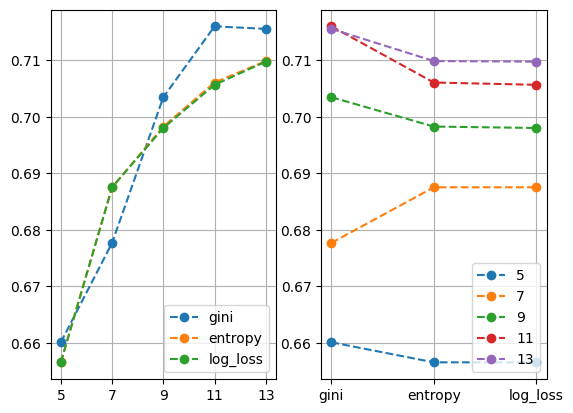

In [31]:
relation_matrix = np.array(combs, dtype=tuple).reshape((len(criterions),len(max_depths), 2))

for matrix, i, param in zip([relation_matrix, relation_matrix.transpose((1,0,2))], range(1, 3), [max_depths, criterions]):
    plt.subplot(1, 2, i)
    indexes = None
    for p in matrix:
        indexes = np.where([np.array([(y[0],y[1]) == (x[0],x[1]) for x in p]).any() for y in combs])[0]
        
        plt.plot(range(len(p)), [tree_scores_avg[i] for i in indexes], '--o', label=p[0][1-i])
        plt.legend(loc='lower right')

        points_x = [np.full((len(tree_scores[0]),), i) for i in range(len(p))]
        points_y = [tree_scores[i] for i in indexes]
        plt.xticks(range(len(param)),param)
        plt.scatter(points_x, points_y, color='gray', alpha=0.3, s=6)
        plt.grid(axis='both')
    # for x, y in zip(range(len(indexes)),[tree_scores_avg[i] for i in indexes]):
    #     plt.annotate(str(param[x]), (x+0.05, y), bbox={'boxstyle':"round", 'fc':"0.8", 'alpha': 0.5})


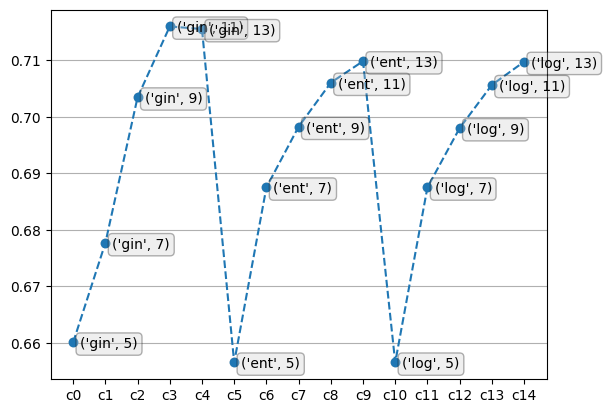

In [32]:
plt.plot([f'c{i}' for i in range(len(tree_scores))],  tree_scores_avg, '--o')
points_x = [np.full((len(tree_scores[0]),),i)for i in range(len(tree_scores))]
for x, y in zip(points_x, tree_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')

labels = [str((x[0][:3], x[1])) for x in combs]

for x, y in zip(range(len(tree_scores_avg)), tree_scores_avg):
    plt.annotate(str(labels[x]), (x+0.22, y-0.001),
                 bbox={'boxstyle': "round", 'fc': "0.8", 'alpha': 0.3})
None

In [33]:
comb = list(it.product(criterions, max_depths))[np.argmax(tree_scores_avg)]

In [34]:
tree_model = sio.loads(sio.load("tree_model3.skops", trusted=True), trusted=True)

In [35]:
print("Best Combination: ", comb)

Best Combination:  ('gini', 11)


In [36]:
if not os.path.exists('tree_model3.skops'):
    tree_model = DecisionTreeClassifier(criterion=comb[0],max_depth=comb[1])
    tree_model.fit(flat_train_x, train_y)
print(f'Accuracy: {tree_model.score(flat_test_x, test_y)}')

Accuracy: 0.7159


#### Por que esses valores?

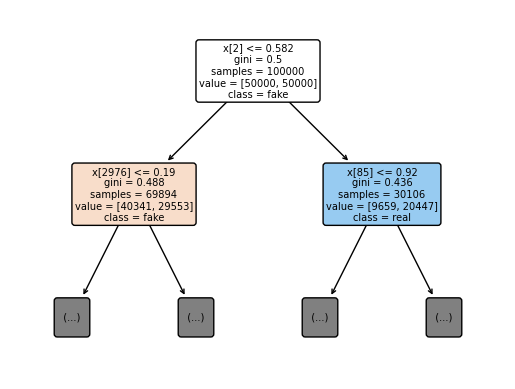

In [37]:
plt.close()
plot_tree(tree_model, class_names=['fake', 'real'], max_depth=1,filled=True, rounded=True)
plt.show()


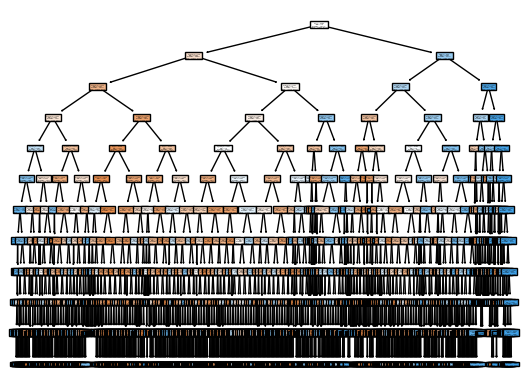

In [38]:
plot_tree(tree_model, filled=True)
plt.show()


In [39]:
tree_xx_i = auxiliar_indexes(len(flat_train_x), 2000)
tree_model_vis = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
tree_model_vis.fit(flat_train_x[tree_xx_i][:, :2], train_y[tree_xx_i])
None


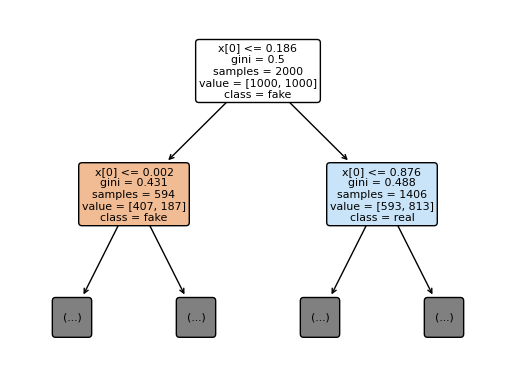

In [40]:
plot_tree(tree_model_vis, class_names=['fake', 'real'], max_depth=1, filled=True, rounded=True)
plt.show()


In [41]:
children_left = tree_model_vis.tree_.children_left
children_right = tree_model_vis.tree_.children_right
feature = tree_model_vis.tree_.feature
threshold = tree_model_vis.tree_.threshold
classes = tree_model_vis.tree_.value

limits = [[(0,1), (0,1)]]
stack = [0]
decisions = []
while len(stack) > 0:
    limit_x, limit_y = limits.pop()
    i = stack.pop()
    is_split_node = children_left[i] != children_right[i]
    
    if not is_split_node:
        continue
    
    left_class = np.argmax(classes[children_left[i]][0])
    right_class = np.argmax(classes[children_right[i]][0])
    if feature[i] == 0:
        limits.append([limit_x, (threshold[i], limit_y[1])])
        limits.append([limit_x, (limit_y[0], threshold[i])])
        a = [limit_x[0], limit_x[0], limit_x[1], limit_x[1]]
        b = [limit_y[0], threshold[i], threshold[i], limit_y[0]]
        decisions.append([a, b, left_class])
        b = [limit_y[1], threshold[i], threshold[i], limit_y[1]]
        decisions.append([a, b, right_class])
    else:
        limits.append([(threshold[i], limit_x[1]), limit_y])
        limits.append([(limit_x[0], threshold[i]), limit_y])
        a = [limit_x[0], threshold[i], threshold[i], limit_x[0]]
        b = [limit_y[0], limit_y[0], limit_y[1], limit_y[1]]
        decisions.append([a, b, left_class])
        a = [limit_x[1], threshold[i], threshold[i], limit_x[1]]
        decisions.append([a, b, right_class])
    stack.append(children_right[i])
    stack.append(children_left[i])


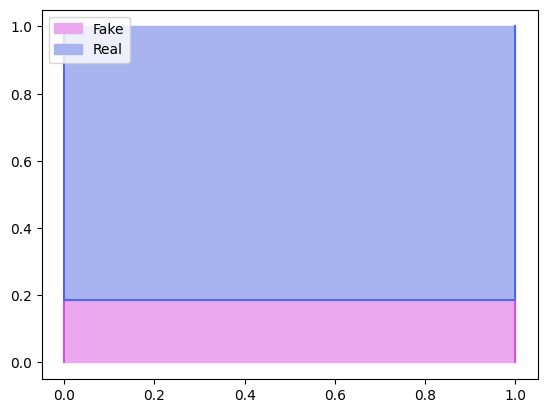

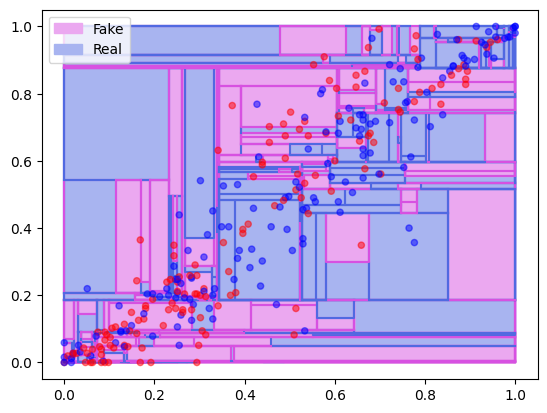

In [42]:
c_map1 = ['#eba8f0', '#a8b4f0']
c_map2 = ['#d751e1', '#5169e1']
c_map3 = ['r', 'b']

for d in decisions[:2]:
    plt.fill(d[0], d[1], c=c_map1[d[2]], zorder=1)
    plt.plot(d[0], d[1], c=c_map2[d[2]], zorder=2)
plt.legend([plt.Polygon([[0, 0]], color=c_map1[0]), plt.Polygon([[0, 0]], color=c_map1[1])], ['Fake', 'Real'], loc='upper left')
plt.show()

for d in decisions:
    plt.fill(d[0],d[1], c=c_map1[d[2]], zorder=1)
    plt.plot(d[0],d[1], c=c_map2[d[2]], zorder=2)
plt.legend([plt.Polygon([[0, 0]], color=c_map1[0]), plt.Polygon([[0, 0]], color=c_map1[1])], ['Fake', 'Real'], loc='upper left')

count = 300
plt.scatter(flat_train_x[tree_xx_i][:count,1], flat_train_x[tree_xx_i][:count,0], c=[c_map3[int(y)] for y in train_y[tree_xx_i][:count]], s=20, alpha=0.5, zorder=3)
plt.show()


In [43]:
tree_proba = tree_model.predict_proba(flat_test_x)

In [44]:
if not os.path.exists('tree_model3.skops'):
    obj = sio.dumps(tree_model)
    sio.dump(obj, "tree_model3.skops")


### Rede Neural Artificial(RNN)

In [45]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, PReLU, ReLU, LeakyReLU
from keras.models import Sequential, load_model
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy

In [46]:
layerCounts = [1,2,3,4]
ann_scores = []
iterations = 20
if not os.path.exists('ann_scores'):
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 10000) for _ in range(iterations)]
    for layer in layerCounts: 
        for i in it.product([50], repeat=layer):
            mean = []
            for m in range(iterations):
                ann_model = Sequential()
                for k in i:
                    ann_model.add(Dense(k, activation="relu"))
                ann_model.add(Dense(2, "sigmoid"))
                ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
                ann_model.fit(flat_train_x[b[m]], train_y[b[m]], epochs=5, use_multiprocessing=True, verbose=False)
                mean.append(ann_model.evaluate(flat_test_x[a[m]], test_y[a[m]], use_multiprocessing=True, verbose=False)[1])
                gc.collect()
            ann_scores.append(mean)


In [47]:
ann_scores = sio.loads(sio.load("ann_scores", trusted=True), trusted=True)

In [48]:
np.shape(ann_scores)

(4, 20)

In [49]:
if not os.path.exists('ann_scores'):
    sio.dump(sio.dumps(ann_scores), "ann_scores")

In [50]:
ann_scores_avg = [np.mean(i) for i in ann_scores]


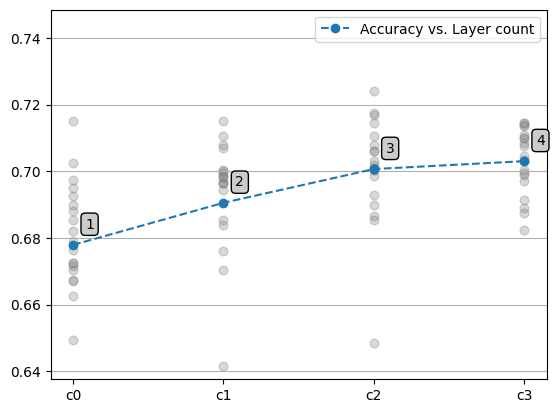

In [51]:
plt.plot([f'c{i}' for i in range(len(ann_scores))],
         ann_scores_avg, '--o', label='Accuracy vs. Layer count')
plt.legend()
points_x = [np.full((len(ann_scores[0]),),x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')
for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(layerCounts[x]), (x+0.08, y+0.005), bbox={'boxstyle': "round", 'fc': "0.8"})
plt.ylim([np.mean(ann_scores_avg)*0.92, np.mean(ann_scores_avg)*1.08])
None

In [52]:
layerCount = layerCounts[np.argmax([np.mean(x) for x in ann_scores])]

In [53]:
ann_scores = []
iterations = 20
outputSizes = [list(it.repeat(x, layerCount)) for x in [32,64,128,256]]
outputSizes.append([32, 64, 128, 256])
outputSizes.append([256, 128, 64, 32])

if not os.path.exists('ann_scores1'):
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 10000) for _ in range(iterations)]
    for i in outputSizes:
        mean = []
        for m in range(iterations):
            ann_model = Sequential()
            for k in i:
                ann_model.add(Dense(k, activation="relu"))
            ann_model.add(Dense(2, "sigmoid"))
            ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
            ann_model.fit(flat_train_x[b[m]], train_y[b[m]], epochs=5, use_multiprocessing=True, verbose=False)
            mean.append(ann_model.evaluate(flat_test_x[a[m]], test_y[a[m]], use_multiprocessing=True, verbose=False)[1])
        ann_scores.append(mean)


In [54]:
outputSizes

[[32, 32, 32, 32],
 [64, 64, 64, 64],
 [128, 128, 128, 128],
 [256, 256, 256, 256],
 [32, 64, 128, 256],
 [256, 128, 64, 32]]

In [55]:
ann_scores = sio.loads(sio.load("ann_scores1", trusted=True), trusted=True)


In [56]:
if not os.path.exists('ann_scores1'):
    sio.dump(sio.dumps(ann_scores), "ann_scores1")

In [57]:
ann_scores_avg = [np.mean(x) for x in ann_scores]

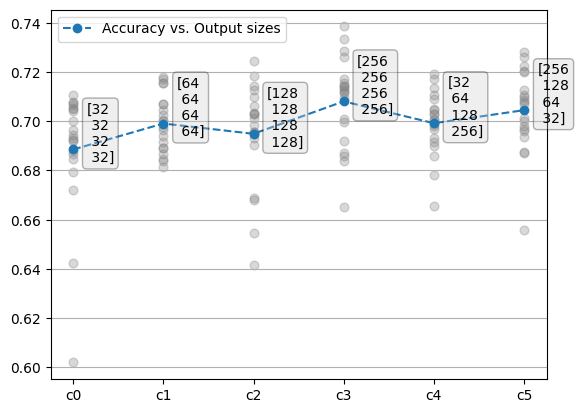

In [58]:
plt.plot([f'c{i}' for i in range(len(ann_scores))], ann_scores_avg, '--o', label='Accuracy vs. Output sizes')
plt.legend()
points_x = [np.full((len(ann_scores[0]),), x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')

for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(outputSizes[x]).replace(',', '\n'), (x+0.15, y-0.005),
                 bbox={'boxstyle': "round", 'fc': "0.8", 'alpha': 0.3})


In [59]:
sizes = outputSizes[np.argmax([np.mean(x) for x in ann_scores])]
print(sizes)

[256, 256, 256, 256]


In [60]:
ann_scores = []
iterations = 20
activations = [ 'leaky2', 'relu', 'leaky1']

if not os.path.exists('ann_scores2'):
    a = [auxiliar_indexes(len(flat_test_x), 2000) for _ in range(iterations)]
    b = [auxiliar_indexes(len(flat_train_x), 10000) for _ in range(iterations)]
    for i in activations:
        mean = []
        for m in range(iterations):
            ann_model = Sequential()
            for size in sizes:
                ann_model.add(Dense(k))
                if i == "relu":
                    ann_model.add(ReLU())
                elif i == 'leaky1':
                    ann_model.add(LeakyReLU(alpha=0.1))
                else:
                    ann_model.add(LeakyReLU(alpha=0.2))
            ann_model.add(Dense(2, "sigmoid"))
            ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
            ann_model.fit(flat_train_x[b[m]], train_y[b[m]], epochs=5, use_multiprocessing=True, verbose=False)
            mean.append(ann_model.evaluate(flat_test_x[a[m]], test_y[a[m]], use_multiprocessing=True, verbose=False)[1])
            gc.collect()
        ann_scores.append(mean)
        print(ann_scores[-1])


In [61]:
if not os.path.exists('ann_scores2'):
    sio.dump(sio.dumps(ann_scores), "ann_scores2")

In [62]:
ann_scores = sio.loads(sio.load("ann_scores2", trusted=True), trusted=True)

In [63]:
ann_scores_avg = [np.mean(x) for x in ann_scores]

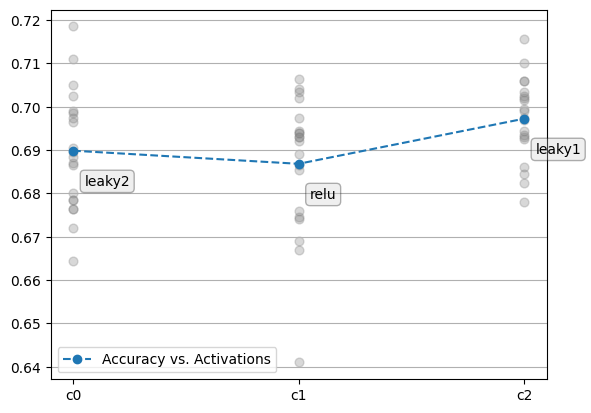

In [64]:
plt.plot([f'c{i}' for i in range(len(ann_scores))],
         [np.mean(x) for x in ann_scores], '--o', label='Accuracy vs. Activations')
plt.legend()
points_x = [np.full((len(ann_scores[0]),), x) for x in range(len(ann_scores))]
for x, y in zip(points_x, ann_scores):
    plt.scatter(x, y, color='gray', alpha=0.3, s=40)
plt.grid(axis='y')

for x, y in zip(range(len(ann_scores_avg)), ann_scores_avg):
    plt.annotate(str(activations[x]).replace(',', '\n'), (x+0.05, y-0.008),
                 bbox={'boxstyle': "round", 'fc': "0.8", 'alpha': 0.3})


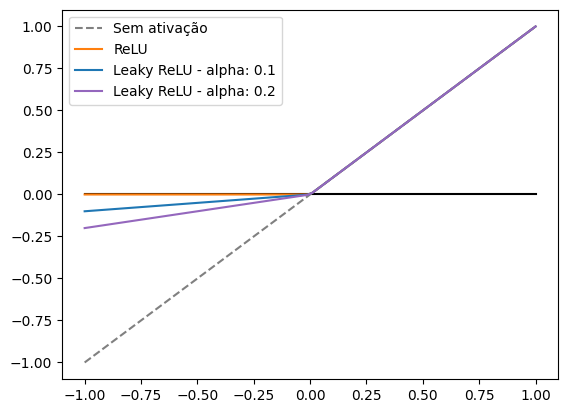

In [65]:
def plot_func(func, name, color, style='-'):
    x = np.linspace(-1, 1, 100)
    y =  func(x)
    plt.plot(x, y, style, label=name, color=color)

plot_func(lambda x: x*0, '', 'k', '-')
plot_func(lambda x: x, 'Sem ativação', 'gray', '--')
plot_func(lambda x: np.maximum(0, x), 'ReLU', 'C1')
plot_func(lambda x: np.maximum(0.1*x, x), 'Leaky ReLU - alpha: 0.1', 'C0')
plot_func(lambda x: np.maximum(0.2*x, x), 'Leaky ReLU - alpha: 0.2', 'C4')
plt.legend()

In [66]:
ann_model = Sequential()

for size in sizes:
    ann_model.add(Dense(size))
    ann_model.add(LeakyReLU(alpha=0.1))
ann_model.add(Dense(2, activation="sigmoid"))

In [67]:
ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])

In [68]:
if os.path.exists('ann_model'):
    ann_model = load_model('ann_model')
    with open('ann_fit.txt', 'r') as f:
        print(f.read())
else:
    ann_model.fit(flat_train_x, train_y, epochs=10, validation_split=0.2, use_multiprocessing=True)
    # ann_model.save('ann_model')

Epoch 1/10
2500/2500 [==============================] - 97s 36ms/step - loss: 0.4772 - acc: 0.7666 - val_loss: 0.9784 - val_acc: 0.4115
Epoch 2/10
2500/2500 [==============================] - 91s 36ms/step - loss: 0.4522 - acc: 0.7823 - val_loss: 0.7151 - val_acc: 0.6288
Epoch 3/10
2500/2500 [==============================] - 54s 22ms/step - loss: 0.4329 - acc: 0.7935 - val_loss: 0.8810 - val_acc: 0.5160
Epoch 4/10
2500/2500 [==============================] - 50s 20ms/step - loss: 0.4180 - acc: 0.8025 - val_loss: 0.7589 - val_acc: 0.6057
Epoch 5/10
2500/2500 [==============================] - 50s 20ms/step - loss: 0.4053 - acc: 0.8094 - val_loss: 0.6058 - val_acc: 0.6692
Epoch 6/10
2500/2500 [==============================] - 56s 22ms/step - loss: 0.3930 - acc: 0.8166 - val_loss: 0.4741 - val_acc: 0.7646
Epoch 7/10
2500/2500 [==============================] - 53s 21ms/step - loss: 0.3809 - acc: 0.8240 - val_loss: 0.5728 - val_acc: 0.6944
Epoch 8/10
2500/2500 [==========================

In [69]:
res = ann_model.evaluate(flat_test_x, test_y, verbose=False)
print(f'Accuracy: {res[1]}')

Accuracy: 0.8187000155448914


In [70]:
ann_proba = ann_model.predict(flat_test_x, use_multiprocessing=True, verbose=False)

In [71]:
def normalize_matrix(matrix):
    mn, mx = matrix.min(), matrix.max()
    if(mn < 0):
        mn *= -1
    else:
        mn = 0
    return (matrix+mn)/(mx+mn)


In [72]:
weights, bias = ann_model.layers[2].get_weights()

In [73]:
np.shape(weights)

(256, 256)

In [74]:
weights = weights[:3,:2]

#### Por que esses valores?

In [75]:

def plot_single_layer(weights, h_start, h_count):
    lim = 5
    v_gap = 1
    h_gap = 1
    v_count = len(weights)
    end_count = len(weights[0])
    h_offset = (lim / 2-(h_gap*(h_count-1)/2)) + 0 * h_gap
    p = plt.gca()
    for i in range(end_count):
        end = (lim / 2-(v_gap*(end_count-1)/2)) + i * v_gap
        x = np.full((v_count,2), [h_offset+h_start*h_gap, h_offset+h_start*h_gap+h_gap]).flatten()
        y = (np.array(range(v_count)) * v_gap)+(lim /2-(v_gap*(v_count-1)/2))
        y = np.array([list(y), list(it.repeat(end, v_count))]).transpose().flatten()
        widths = np.abs(weights[:, i])
        widths = (widths / np.max(widths))*5
        
        ps = list(np.array([list(x),list(y)]).transpose().flatten())
        ps = np.array(ps).reshape(v_count,2,2)
        
        c_map = ['g','b']
        col = LineCollection(ps,
                            linewidths=widths, colors=[c_map[np.argmax([k, 0])] for k in weights[:, i]], capstyle='round')
        
        p.add_collection(col)
        p.set_xlim(0,lim)
        p.set_ylim(0,lim)
        plt.xticks([])
        plt.yticks([])
        p.scatter(x,y, s=100, c="C1", zorder=3)
        

In [76]:
def plot_layers(layers):
    for i, j in zip(range(len(layers)), range(len(layers), 0, -1)):
        plot_single_layer(np.array(layers[i][:j+1, :j]), i, len(layers))

In [85]:
gc.collect()

488

In [78]:

weights_plot = []
ann_model.compile(optimizer=Adamax(),
                  loss=SparseCategoricalCrossentropy(), metrics=['acc'])
b = [auxiliar_indexes(len(flat_train_x), 5000) for _ in range(5)]
for x in range(5):   
   ann_model.fit(flat_train_x[b[x]], train_y[b[x]], epochs=1, use_multiprocessing=True, verbose=False)
   model_weights = []
   for i in range(0, len(ann_model.layers), 2):
      w, _ = ann_model.layers[i].get_weights()
      model_weights.append(w)
   weights_plot.append(model_weights)

RuntimeError: Requested MovieWriter (ffmpeg) not available

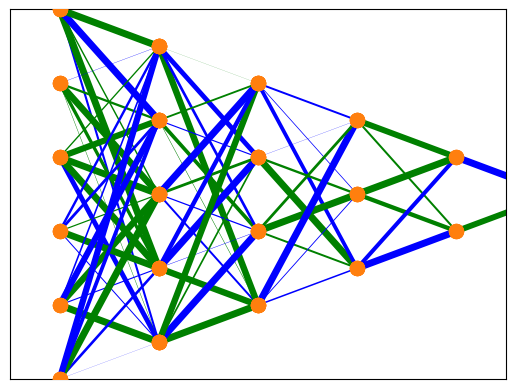

In [79]:

# %matplotlib inline
# plt.figure(0)
# for i in range(len(weights_plot)):
#     # plt.gca().clear()
#     clear_output(False)
#     plot_layers(weights_plot[i])
#     plt.show()
#     # plt.gca().draw()
#     time.sleep(3)
# f, g = plt.subplots()
plt.close()
def animat(i):
    plt.gca().clear()
    plot_layers(weights_plot[i])
# clear_output()
# np.shape(np.asarray(weights_plot[0]))

ani = FuncAnimation(plt.gcf(), animat, frames=[0,1,2,3,4], interval=200, repeat=False, cache_frame_data=False)
ani.save("t.gif", PillowWriter())
# display(HTML(ani.to_html5_video()))
# plt.show()
# print(None)


In [ ]:
sio.dump(sio.dumps(weights_plot), "ann_weights.skops")

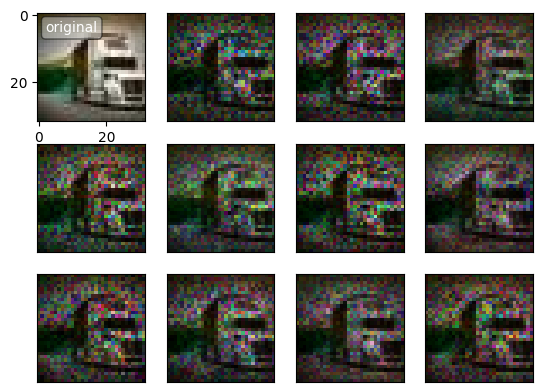

In [ ]:
plt.subplot(3, 4, 1)
plt.imshow(test_x[0])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})
for i in range(2, 13):
    processed_img = weights[:, i-2].reshape(32, 32, 3)
    processed_img = normalize_matrix(processed_img)
    processed_img = np.multiply(processed_img, test_x[0])
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(processed_img)


In [ ]:
processed_img = Sequential(layers=ann_model.layers[:2]).predict(flat_test_x[:1])
processed_img = normalize_matrix(processed_img.reshape((16, 16)))


1/1 [==============================] - 0s 119ms/step


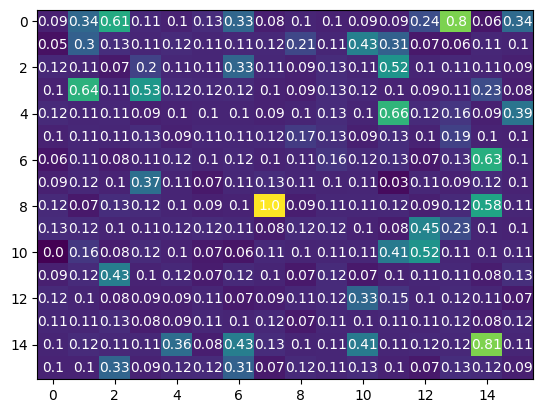

In [ ]:
plt.imshow(processed_img, interpolation='nearest', aspect='auto')

for x in range(len(processed_img)):
    for y in range(len(processed_img[x])):
            plt.text(y,x, round(processed_img[x][y], 2), ha="center",va='center', color="w")

### Rede Neural Convolucional(Cnn)

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(128, 3, input_shape=(32,32,3)))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 3))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPool2D())

cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(256))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dense(2, activation="sigmoid"))

In [ ]:
cnn_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [ ]:
if os.path.exists('cnn_model'):
    cnn_model = load_model('cnn_model')
    with open('cnn_fit.txt', 'r') as f:
        print(f.read())
else:
    cnn_model.fit(train_x, train_y, epochs=5, use_multiprocessing=True, batch_size=64, validation_split=0.2)
    cnn_model.save("cnn_model")


Epoch 1/5
1250/1250 [==============================] - 640s 509ms/step - loss: 0.3115 - accuracy: 0.8638 - val_loss: 0.3730 - val_accuracy: 0.8370
Epoch 2/5
1250/1250 [==============================] - 610s 488ms/step - loss: 0.1942 - accuracy: 0.9226 - val_loss: 0.6428 - val_accuracy: 0.7273
Epoch 3/5
1250/1250 [==============================] - 596s 477ms/step - loss: 0.1600 - accuracy: 0.9370 - val_loss: 0.2730 - val_accuracy: 0.9044
Epoch 4/5
1250/1250 [==============================] - 673s 537ms/step - loss: 0.1307 - accuracy: 0.9491 - val_loss: 0.2077 - val_accuracy: 0.9222
Epoch 5/5
1250/1250 [==============================] - 407s 325ms/step - loss: 0.1088 - accuracy: 0.9589 - val_loss: 0.2444 - val_accuracy: 0.9194


In [ ]:
xx_i = auxiliar_indexes(len(train_x), 10)

In [ ]:
cnn_model.fit(train_x[xx_i], train_y[xx_i], epochs=1, use_multiprocessing=True, validation_split=0.2)

1/1 [==============================] - 3s 3s/step - loss: 0.6974 - accuracy: 0.3750 - val_loss: 0.7777 - val_accuracy: 0.0000e+00


In [ ]:
cnn_model.evaluate(test_x, test_y, use_multiprocessing=True)

625/625 [==============================] - 40s 61ms/step - loss: 0.1736 - accuracy: 0.9395


[0.17361047863960266, 0.9394500255584717]

In [ ]:
cnn_proba = cnn_model.predict(test_x, use_multiprocessing=True)

625/625 [==============================] - 45s 71ms/step


In [ ]:
filters, bias = cnn_model.layers[0].get_weights()

#### Por que esses valores?

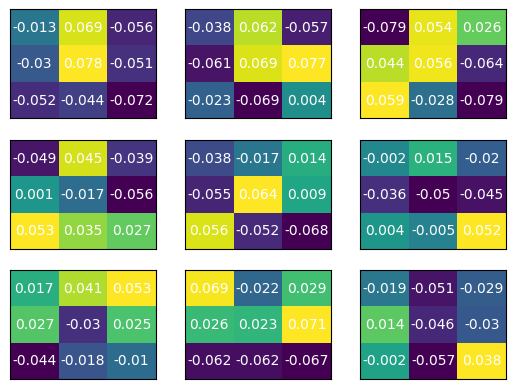

In [ ]:
for i in range(1,10):
    plt.subplot(3,3,i)
    f = filters[:,:,0,i-1]
    plt.xticks([])
    plt.yticks([])
    plt.imshow(f, aspect='auto', interpolation='nearest')

    for x in range(len(f)):
        for y in range(len(f[x])):
            text = plt.text(y,x, round(f[x][y], 3),
                   ha="center",va='center', color="w")


In [ ]:
feature_maps = Sequential(layers=cnn_model.layers[:1]).predict(test_x[2:3])

1/1 [==============================] - 0s 131ms/step


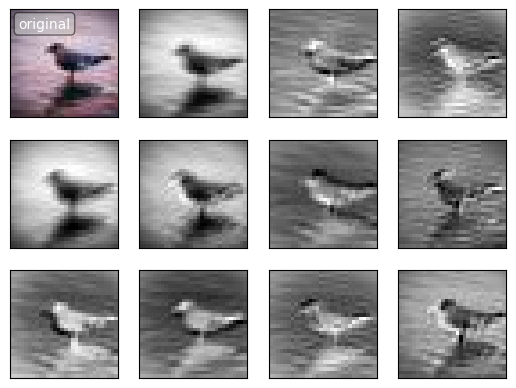

In [ ]:
plt.subplot(3,4,1)
plt.xticks([])
plt.yticks([])
plt.imshow(test_x[2])
plt.annotate("original",[2,5], color='w', bbox={'boxstyle': 'round', 'fc': '0.8', 'alpha': 0.5})

for i in range(2,13):
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0][:,:,i+11], cmap='gray')

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

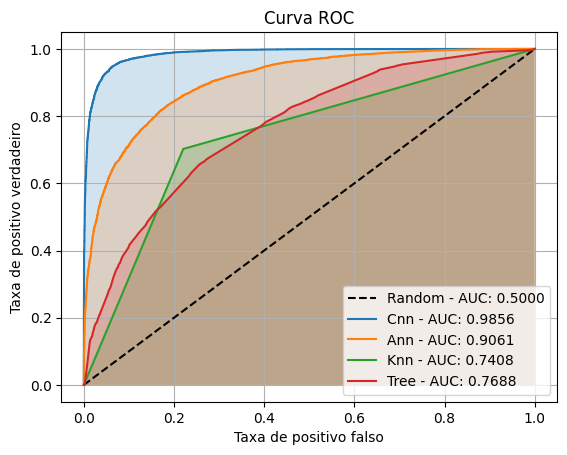

In [ ]:
plt.plot([0,1], [0,1], '--', color='black', label='Random - AUC: 0.5000')
for proba, name in zip([cnn_proba, ann_proba,knn_proba, tree_proba], ['Cnn', 'Ann', 'Knn', 'Tree' ]):
    fpr, tpr, _ = roc_curve(test_y, proba.transpose()[0])
    auc = str(round(1 - roc_auc_score(test_y, proba.transpose()[0]), 4)).ljust(6, '0')
    plt.fill([*tpr, tpr[-1]], [*fpr, 0], alpha=0.2)
    plt.plot(tpr, fpr, label=f'{name} - AUC: {auc}')
    plt.legend(loc='lower right')
plt.ylabel('Taxa de positivo verdadeiro')
plt.xlabel('Taxa de positivo falso')
plt.title('Curva ROC')
plt.grid()


In [ ]:
css_style()
